# Sentiment Analysis

* [Data Acquisition](#Data-Acquisition)
* [Discovery](#Discovery)
* [Naive Bayes Model](#Naive-Bayes-Model)
* [Logistic Regression](#Logistic-Regression)

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk                                  
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer #Convert a collection of text documents to a matrix of token counts
from sklearn.model_selection import train_test_split



## Data Acquisition

The dataset was downloaded from [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)

In [2]:
dataset= pd.read_csv('Tweets.csv', sep=',')
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Discovery

In [3]:
print("Number of tweets: ", len(dataset))

Number of tweets:  14640


In [4]:
dataset['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

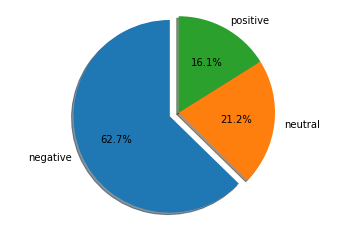

In [5]:
pivot = dataset.pivot_table(index=['airline_sentiment'], values=['tweet_id'], aggfunc='count', margins=False)
pivot1=pivot.reset_index()
pivot1['percentage']= np.round(100* (pivot1['tweet_id']/pivot1['tweet_id'].sum()),1)
explode = (0.1, 0,0)
fig1, ax1 = plt.subplots()
ax1.pie(pivot1['percentage'], explode=explode, labels=pivot1['airline_sentiment'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [6]:
dataset.pivot_table(index='airline', values='tweet_id', columns='airline_sentiment', aggfunc='count', margins=True)

airline_sentiment,negative,neutral,positive,All
airline,,,,
American,1960,463,336,2759
Delta,955,723,544,2222
Southwest,1186,664,570,2420
US Airways,2263,381,269,2913
United,2633,697,492,3822
Virgin America,181,171,152,504
All,9178,3099,2363,14640


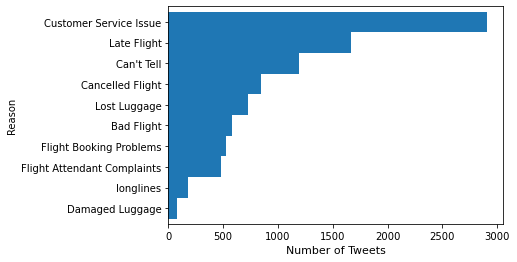

In [7]:
neg_reviews=dataset[dataset['airline_sentiment']=='negative']
feq=neg_reviews.pivot_table(index='negativereason', values='tweet_id', aggfunc='count')
feq=feq.sort_values(by='tweet_id', ascending=True)
feq.plot.barh(figsize=(6,4),  width= 1)
plt.xlabel('Number of Tweets', fontsize = 11)
plt.ylabel('Reason')
plt.legend().set_visible(False)
plt.show()

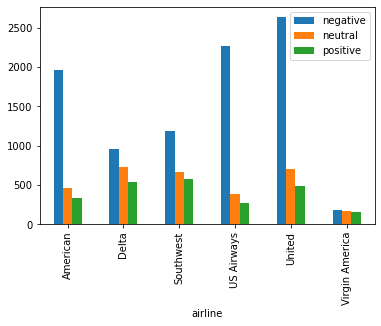

In [8]:
pivot = dataset.pivot_table(index=['airline'], 
                            columns=['airline_sentiment'],
                            values=['tweet_id'], 
                            aggfunc='count', margins=False).fillna(0)
pivot.columns = pivot.columns.droplevel(0) #Remover el indice multilevel en las columnas
pivot = pivot.rename_axis(None, axis=1)
pivot.plot(kind='bar', stacked=False)
plt.show()

In [9]:
tweet_df = dataset[dataset['airline_sentiment'] != 'neutral'] #Removing the tweets associated with neutral reviews
tweet_df=tweet_df[['text','airline_sentiment']]
tweet_df.head()

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [10]:
sentiment_label = tweet_df.airline_sentiment.factorize()
sentiment_label ##Positive 0, Negative 1

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

In [11]:
sentiment_label=sentiment_label[0]
sentiment_label

array([0, 1, 1, ..., 0, 1, 1])

In [12]:
tweet = tweet_df.text.to_list()
tweet[0:3]

["@VirginAmerica plus you've added commercials to the experience... tacky.",
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "@VirginAmerica and it's a really big bad thing about it"]

In [13]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [14]:
process_tweet(tweet[0])

['plu', 'ad', 'commerci', 'experi', '...', 'tacki']

In [15]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1    
    return freqs

In [16]:
freqs = build_freqs(tweet, sentiment_label)
freqs

{('plu', 0): 7,
 ('ad', 0): 13,
 ('commerci', 0): 8,
 ('experi', 0): 38,
 ('...', 0): 104,
 ('tacki', 0): 1,
 ('realli', 1): 235,
 ('aggress', 1): 3,
 ('blast', 1): 5,
 ('obnoxi', 1): 2,
 ('entertain', 1): 21,
 ('guest', 1): 4,
 ('face', 1): 17,
 ('littl', 1): 45,
 ('recours', 1): 5,
 ('big', 1): 38,
 ('bad', 1): 160,
 ('thing', 1): 86,
 ('serious', 1): 74,
 ('would', 1): 367,
 ('pay', 1): 158,
 ('flight', 1): 3593,
 ('seat', 1): 382,
 ('play', 1): 19,
 ('fli', 1): 407,
 ('va', 1): 7,
 ('ye', 0): 50,
 ('nearli', 0): 1,
 ('everi', 0): 15,
 ('time', 0): 112,
 ('fli', 0): 133,
 ('vx', 0): 2,
 ('“', 0): 42,
 ('ear', 0): 1,
 ('worm', 0): 1,
 ('”', 0): 29,
 ('’', 0): 18,
 ('go', 0): 58,
 ('away', 0): 14,
 (':)', 0): 108,
 ('well', 0): 48,
 ('…', 0): 9,
 (':-d', 0): 1,
 ('amaz', 0): 81,
 ('arriv', 0): 12,
 ('hour', 0): 22,
 ('earli', 0): 20,
 ('good', 0): 111,
 ('<3', 0): 12,
 ('pretti', 0): 10,
 ('graphic', 0): 2,
 ('much', 0): 109,
 ('better', 0): 36,
 ('minim', 0): 1,
 ('iconographi', 0): 

In [17]:
keys = ['bad', 'good', 'better', 'sad', 'mad', 'best', 'pretti','excit', 'awesom',
        'flight','big', 'time', 'thank','experi','work','hour','never', 'always',
        'email','call','respons','problem','custom', 'service',
         ':)', ':(', '😊','😒', '😬', '😄', '😍', '😡', '😢','👎' ,'👏']

# each element consist of a sublist with this pattern: [<word>, <negative_count>, <positive_count>]
data = []
for word in keys:
    
    # initializing counts
    pos = 0
    neg = 0
    if (word, 1) in freqs:
        pos = freqs[(word, 1)]
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]
        
    data.append([word, pos, neg])
    
data

[['bad', 160, 17],
 ['good', 146, 111],
 ['better', 133, 36],
 ['sad', 32, 1],
 ['mad', 12, 4],
 ['best', 63, 105],
 ['pretti', 29, 10],
 ['excit', 6, 21],
 ['awesom', 17, 102],
 ['flight', 3593, 444],
 ['big', 38, 27],
 ['time', 749, 112],
 ['thank', 399, 1071],
 ['experi', 172, 38],
 ['work', 276, 85],
 ['hour', 1094, 22],
 ['never', 281, 21],
 ['always', 0, 0],
 ['email', 200, 12],
 ['call', 695, 32],
 ['respons', 161, 61],
 ['problem', 235, 27],
 ['custom', 777, 124],
 ['service', 0, 0],
 [':)', 20, 108],
 [':(', 75, 4],
 ['😊', 3, 22],
 ['😒', 14, 1],
 ['😬', 1, 0],
 ['😄', 4, 4],
 ['😍', 0, 7],
 ['😡', 32, 0],
 ['😢', 11, 6],
 ['👎', 15, 0],
 ['👏', 7, 20]]

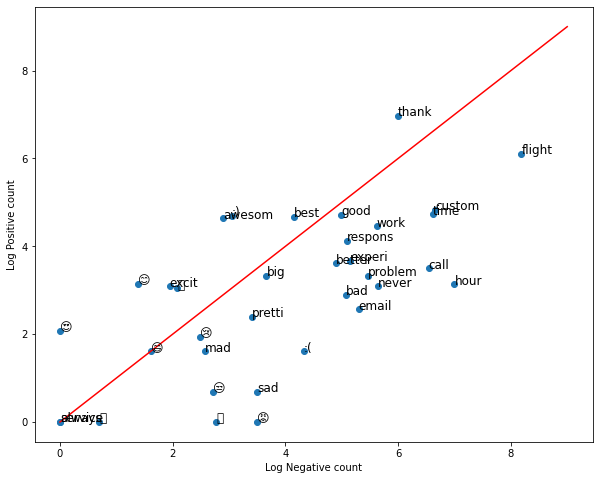

In [19]:
fig, ax = plt.subplots(figsize = (10, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  
y = np.log([x[2] + 1 for x in data]) 

ax.scatter(x, y)  

plt.xlabel("Log Negative count")
plt.ylabel("Log Positive count")

for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red')
plt.show()

In [20]:
sentiment_label=tweet_df.airline_sentiment.factorize()
tweet_df['label']=sentiment_label[0]

In [21]:
tweet_df.head()

,text,airline_sentiment,label
1,@VirginAmerica plus you've added commercials t...,positive,0
3,@VirginAmerica it's really aggressive to blast...,negative,1
4,@VirginAmerica and it's a really big bad thing...,negative,1
5,@VirginAmerica seriously would pay $30 a fligh...,negative,1
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,0


In [23]:
tweet_df.pivot_table(index='airline_sentiment', values='label', aggfunc='count')

,label
airline_sentiment,
negative,9178
positive,2363


In [30]:
X_train, X_test, y_train, y_test = train_test_split(tweet_df['text'], 
                                                    tweet_df['label'], 
                                                    random_state=0)

In [31]:
y_train.head()

12087    1
61       1
5891     0
2668     1
9341     1
Name: label, dtype: int64

In [32]:
X_train.head()

12087    @AmericanAir Checked in on app since yesterday...
61       @VirginAmerica I called a 3-4 weeks ago about ...
5891     @SouthwestAir I just received your birthday ca...
2668     @united my flight landed 50 min, but we are be...
9341     @USAirways been on hold for 45 minutes. Is the...
Name: text, dtype: object

In [33]:
'''Vectorization: Process of turning a collection of text documents into numerical feature vectors'''

vectorizer = CountVectorizer() #Tokenization and occurrence counting
corpus = ['This is the first document.',
        'This document is the second document.',
        'And this is the third one.',
        'Is this the first document?']

X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.toarray()) 

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


## Naive Bayes Model

### Using the words instead of lemmas

In [117]:
vect = CountVectorizer().fit(X_train)
X_train_vectorized = vect.transform(X_train)

model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))

def classification_report(y_test, predictions):
    roc=roc_auc_score(y_test, predictions)
    confusion_m=confusion_matrix(y_test,predictions)
    return print('ROC: ', roc,  '\n Confussion_matrix: \n', confusion_m)
    
classification_report(y_test, predictions)   

ROC:  0.8613654430675707 
 Confussion_matrix: 
 [[ 462  149]
 [  76 2199]]


In [118]:
print(vect.get_feature_names()[0:1070]) 

['00', '000', '000ft', '000lbs', '0016', '00a', '00am', '00pm', '01', '0162389030167', '0162424965446', '0162431184663', '02', '03', '0316', '0372389047497', '05', '0510', '05am', '05pm', '0600', '0671', '08', '0bjnz4eix5', '0hxlnvzknp', '0kn7pjelzl', '0prgysvurm', '0wbjawx7xd', '0xjared', '10', '100', '1000', '1001', '1002', '1007', '101', '1020', '1027', '1028', '1030pm', '1032', '104', '1046', '105', '1050', '1051', '106', '1071', '1074', '1079871763', '1080', '1086', '108639', '10a', '10am', '10f', '10hrs', '10m', '10min', '10mins', '10p', '10pm', '10th', '10voucherwhatajoke', '11', '1106', '1108', '1109', '1114', '1117', '112', '1130pm', '1137', '1138', '1140', '1142', '1146', '1152', '1153', '1156', '1161', '117', '1171', '1172', '118', '1180', '1181', '11a', '11am', '11pm', '11th', '12', '120', '1200', '1219', '122', '1225', '1228', '123', '1230', '1230am', '1242', '125', '1254', '125k', '1261', '1265', '127', '1274', '1278', '1285', '129', '12b', '12h', '12h30am', '12pm', '12th

In [119]:
len(vect.get_feature_names())

10772

### Using the Word Net Lemmatizer

In [137]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
vect = CountVectorizer(tokenizer=LemmaTokenizer(),
                      lowercase=True,
                       stop_words='english',
                      min_df=5).fit(X_train)
X_train_vectorized = vect.transform(X_train)

model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))

classification_report(y_test, predictions)   

/Users/anmarphy/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/anmarphy/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


ROC:  0.8766238017301846 
 Confussion_matrix: 
 [[ 493  118]
 [ 122 2153]]


In [138]:
len(vect.get_feature_names())

1930

In [139]:
print(vect.get_feature_names()) 

['!', '#', '$', '%', '&', "'", "''", "'d", "'ll", "'m", "'re", "'s", "'ve", '(', ')', '*', '+', ',', '-', '--', '.', '..', '...', '....', '.....', '/', '0', '1', '1.5', '1/2', '10', '10,000', '100', '1000', '11', '12', '13', '14', '140', '15', '150', '16', '17', '18', '180', '1800', '19', '1hr', '1k', '1st', '2', '2+', '2.5', '2/19', '2/2', '20', '20+', '200', '2015', '20min', '22', '23', '24', '24hrs', '25', '2day', '2hrs', '2nd', '3', '3-4', '30', '30+', '300', '30min', '32', '35', '36', '3am', '3pm', '3rd', '3x', '4', '40', '40+', '400', '42', '45', '48', '4hrs', '4th', '5', '5+', '50', '500', '5hrs', '5th', '6', '60', '600', '6am', '7', '70', '728', '75', '7am', '8', '800', '8am', '8pm', '9', '90', '9pm', ':', ';', '=', '?', '@', '``', 'a-list', 'a320', 'aa', 'abc', 'able', 'absolute', 'absolutely', 'absurd', 'abt', 'accept', 'acceptable', 'accepting', 'access', 'accommodate', 'accommodating', 'according', 'account', 'acct', 'accurate', 'act', 'action', 'actual', 'actually', 'ad', 

In [140]:
model.predict(vect.transform(['That experience was terrible']))

array([1])

In [141]:
model.predict(vect.transform(['I enjoy the flight, thanks for the customer service']))

array([0])

In [144]:
model.predict(vect.transform([':(']))

array([1])

### Adding n-grams 

In [153]:
'''analyzer='char_wb' which creates character n-grams only from text inside word boundaries. This should make the model more robust to spelling mistakes.'''

vect = CountVectorizer(min_df=5, 
                       ngram_range=(2,5), 
                       analyzer='char_wb'                    
                      ).fit(X_train) 
X_train_vectorized = vect.transform(X_train)

model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))

classification_report(y_test, predictions)   

ROC:  0.8869254150105215 
 Confussion_matrix: 
 [[ 526   85]
 [ 198 2077]]


## Logistic Regression